# Indian Restaurant Startup Recommendation in Toronto Neighborhood

## Web Scraping Toronto Postal Codes

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json # library to handle JSON files
import requests # library to handle requests
# import k-means from clustering stage
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 
import folium # map rendering library

In [2]:
URL = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

In [3]:
page = requests.get(URL)

In [4]:
soup = BeautifulSoup(page.text, 'html.parser')

In [5]:
columns = ['PostalCode','Borough','Neighborhood']

In [6]:
postaltable = soup.find_all('table')[0]

### Converting Postal Codes html table info to Pandas Dataframe

In [7]:
df = pd.read_html(str(postaltable))

In [8]:
postalcodes = df[0]

In [9]:
postalcodes.columns = columns

In [10]:
postalcodes.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


### Narrow down the dataframe to ignore/exclude Not Assigned Boroughs

In [11]:
postalcodes = postalcodes[postalcodes['Borough'] != 'Not assigned']

### Grouping the Neighborhoods w.r.t each Boroughs

In [12]:
toronto_pcodes = postalcodes.groupby(['PostalCode','Borough'])['Neighborhood'].agg(', '.join).to_frame()

In [13]:
toronto_pcodes = toronto_pcodes.reset_index()

In [14]:
toronto_pcodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 3 columns):
PostalCode      103 non-null object
Borough         103 non-null object
Neighborhood    103 non-null object
dtypes: object(3)
memory usage: 2.5+ KB


In [15]:
toronto_pcodes.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [16]:
toronto_pcodes.shape

(103, 3)

#### Overall 103 postal codes are identified and integrated in the dataframe

# Append Coordinates with help of GeoSpatial data

In [17]:
!wget -q -O 'geospatial_coordinates.csv' http://cocl.us/Geospatial_data
print('data downloaded')

data downloaded


In [18]:
geo_coord = pd.read_csv('geospatial_coordinates.csv')
geo_coord.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Merging Coordinates with Toronto Postal Codes dataframe

In [19]:
toronto_postal_coord = pd.merge(left=toronto_pcodes, right=geo_coord, left_on = 'PostalCode', right_on = 'Postal Code', how='inner')

In [20]:
toronto_postal_coord.drop(columns=['Postal Code'], inplace=True)

In [21]:
toronto_postal_coord.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [22]:
# Toronto Coordinates
Latitude = 43.6532
Longitude = -79.3832

### Toronto Neighborhood map view

In [23]:
map_toronto = folium.Map(location=[Latitude, Longitude], zoom_start = 12)

for lat, lng, lbl in zip(toronto_postal_coord['Latitude'], toronto_postal_coord['Longitude'], toronto_postal_coord['Neighborhood']):
    label = folium.Popup(lbl, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        fill = True,
        color = 'blue',
        fill_color = 'yellow',
        fill_opacity = 0.7,
        parse_html = False
    ).add_to(map_toronto)
map_toronto

## Explore Indian Neighborhoods in Toronto

### Web Scraping Demographics of Toronto

In [24]:
TorontoEthnicURL = 'https://en.wikipedia.org/wiki/Demographics_of_Toronto'

In [25]:
EthnicPage = requests.get(TorontoEthnicURL)

In [26]:
soup1 = BeautifulSoup(EthnicPage.text, 'html.parser')

### Identifying the neighborhoods with highest percentage of specific Ethnic origin

In [27]:
for tag in soup1.findAll('p'):
    if tag.get_text().startswith('The neighbourhoods with the highest percentage of'):
        section = tag
        ethnicpercentage = section.find_next('ul').find_all('li')
ethnicpercentage

[<li>Milliken: 97% (top ethnic origin: Chinese)</li>,
 <li>Steeles: 91% (top ethnic origin: Chinese)</li>,
 <li>Agincourt North: 91% (top ethnic origin: Chinese)</li>,
 <li>Malvern: 90% (top ethnic origin: East Indian)</li>,
 <li>West Humber-Clairville: 87% (top ethnic origin: East Indian)</li>,
 <li>Mount Olive-Silverstone-Jamestown: 87% (top ethnic origin: East Indian)</li>,
 <li>Agincourt South-Malvern West: 86% (top ethnic origin: Chinese)</li>,
 <li>Black Creek: 81% (top ethnic origin: Vietnamese)</li>,
 <li>Rouge: 81% (top ethnic origin: East Indian)</li>,
 <li>Flemingdon Park: 79% (top ethnic origin: East Indian)</li>,
 <li>Thorncliffe Park: 79% (top ethnic origin: Pakistani)</li>]

### Transforming the web scraped data to Pandas Dataframe

In [28]:
cols = ['Neighborhood','Top_Ethnic_Origin']
top_neighborhood_origin = pd.DataFrame(columns=cols)
#top_neighborhood_origin
#top_origin = {}
for i in range(0, len(ethnicpercentage)):
    val = ethnicpercentage[i]
    val = val.string.replace('top ethnic origin','')
    val = val.replace('(','')
    val = val.replace(')','')
    val = val.replace(':','')
    #top_origin[]
    top_neighborhood_origin = top_neighborhood_origin.append( { 'Neighborhood':' '.join(val.split('%')[0].split('-')[-1].split(' ')[:-1]), 'Top_Ethnic_Origin': val.split(' ')[-1]}, ignore_index= True)


    

In [29]:
top_neighborhood_origin

,Neighborhood,Top_Ethnic_Origin
0,Milliken,Chinese
1,Steeles,Chinese
2,Agincourt North,Chinese
3,Malvern,Indian
4,Clairville,Indian
5,Jamestown,Indian
6,Malvern West,Chinese
7,Black Creek,Vietnamese
8,Rouge,Indian
9,Flemingdon Park,Indian


### Narrowing down to Indian Ethnic Origin Neighborhoods

In [30]:
top_neighborhood_origin = top_neighborhood_origin[top_neighborhood_origin['Top_Ethnic_Origin'] == 'Indian']

In [31]:
top_neighborhood_origin

,Neighborhood,Top_Ethnic_Origin
3,Malvern,Indian
4,Clairville,Indian
5,Jamestown,Indian
8,Rouge,Indian
9,Flemingdon Park,Indian


##### Translating specific Neighborhoods to actual or alias neighborhoods to match the postal codes data

In [ ]:
top_neighborhood_origin.loc[top_neighborhood_origin['Neighborhood'] == 'Clairville', 'Neighborhood'] = 'Northwest'

In [33]:
top_neighborhood_origin

,Neighborhood,Top_Ethnic_Origin
3,Malvern,Indian
4,Northwest,Indian
5,Jamestown,Indian
8,Rouge,Indian
9,Flemingdon Park,Indian


### Merging with Postal codes and Borough info

In [34]:
Indian_neighborhood = pd.merge(left=top_neighborhood_origin, right=postalcodes, left_on='Neighborhood', right_on='Neighborhood', how='inner')

In [35]:
Indian_neighborhood

,Neighborhood,Top_Ethnic_Origin,PostalCode,Borough
0,Malvern,Indian,M1B,Scarborough
1,Northwest,Indian,M9W,Etobicoke
2,Jamestown,Indian,M9V,Etobicoke
3,Rouge,Indian,M1B,Scarborough
4,Flemingdon Park,Indian,M3C,North York


### Merging with Coordinates using Geospatial data

In [36]:
Indian_neighborhood = pd.merge(left=Indian_neighborhood, right=geo_coord, left_on='PostalCode', right_on='Postal Code', how='left')

In [37]:
Indian_neighborhood.drop(columns=['Postal Code'], axis=1, inplace=True)

In [38]:
Indian_neighborhood

,Neighborhood,Top_Ethnic_Origin,PostalCode,Borough,Latitude,Longitude
0,Malvern,Indian,M1B,Scarborough,43.806686,-79.194353
1,Northwest,Indian,M9W,Etobicoke,43.706748,-79.594054
2,Jamestown,Indian,M9V,Etobicoke,43.739416,-79.588437
3,Rouge,Indian,M1B,Scarborough,43.806686,-79.194353
4,Flemingdon Park,Indian,M3C,North York,43.725900,-79.340923


### Toronto Indian Neighborhood map view

In [39]:
map_indian_toronto = folium.Map(location=[Latitude, Longitude], zoom_start = 11)

for lat, lng, lbl in zip(Indian_neighborhood['Latitude'], Indian_neighborhood['Longitude'], Indian_neighborhood['Neighborhood']):
    label = folium.Popup(lbl, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 7,
        popup = label,
        fill = True,
        color = 'Blue',
        fill_color = 'Yellow',
        fill_opacity = 0.7,
        parse_html = False
    ).add_to(map_indian_toronto)
map_indian_toronto

### Let's create a function to consume the Foursquare API which returns the Venues details based on the Neighborhood Coordinates requested

### Define Foursquare Credentials and Version

In [40]:
# @hidden_cell

CLIENT_ID = '1XWYOQ0GV5OZHK4E2J2N051LVBLAQGSNW3GBHUZXBZI3RPDW' # your Foursquare ID
CLIENT_SECRET = 'MHSY1JRZTVAFLUYQ0R4HIQVQLQ5XM5THVUBYSWJ4D32XRGLH' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

In [65]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    LIMIT = 20
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Fetch the Venues of corresponding Indian Neighborhoods

In [66]:
Indian_neighborhood_venues = getNearbyVenues(names=Indian_neighborhood['Neighborhood'],
                                   latitudes=Indian_neighborhood['Latitude'],
                                   longitudes=Indian_neighborhood['Longitude']
                                  )

Flemingdon Park
Jamestown
Malvern
Northwest
Rouge


In [67]:
print('Number of unique Categories of Venues present in Indian Neighborhood : {}'.format(len(Indian_neighborhood_venues['Venue Category'].unique())))

Number of unique Categories of Venues present in Indian Neighborhood : 40


In [98]:
Indian_neighborhood_venues.head(20)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Flemingdon Park,43.7259,-79.340923,Sorento Restaurant,43.726575,-79.341989,Italian Restaurant
1,Flemingdon Park,43.7259,-79.340923,Oomomo,43.726429,-79.343283,Discount Store
2,Flemingdon Park,43.7259,-79.340923,Fitness Connection,43.727473,-79.341707,Gym
3,Flemingdon Park,43.7259,-79.340923,Aga Khan Museum,43.725105,-79.332076,History Museum
4,Flemingdon Park,43.7259,-79.340923,Tilley Endurables,43.727033,-79.342926,Clothing Store
5,Flemingdon Park,43.7259,-79.340923,Japanese Canadian Cultural Centre,43.726429,-79.334971,Concert Hall
6,Flemingdon Park,43.7259,-79.340923,Kaiseki Yu-Zen Hashimoto,43.720931,-79.337185,Japanese Restaurant
7,Flemingdon Park,43.7259,-79.340923,Swiss Chalet Rotisserie & Grill,43.726737,-79.341403,Restaurant
8,Flemingdon Park,43.7259,-79.340923,Diwan,43.725002,-79.332019,Middle Eastern Restaurant
9,Flemingdon Park,43.7259,-79.340923,JOEY Don Mills,43.733990,-79.344734,Restaurant


### Grouping Stats of Venues per Indian Neighborhood

In [69]:
Indian_neighborhood_stat = Indian_neighborhood_venues.groupby(['Neighborhood'])['Venue'].count().to_frame()

In [70]:
Indian_neighborhood_stat = Indian_neighborhood_stat.reset_index()

In [71]:
Indian_neighborhood_stat

,Neighborhood,Venue
0,Flemingdon Park,20
1,Jamestown,15
2,Malvern,18
3,Northwest,2
4,Rouge,18


### Visual Exploration of Group stats

#### Venue Stats at Indian Origin Neighborhoods

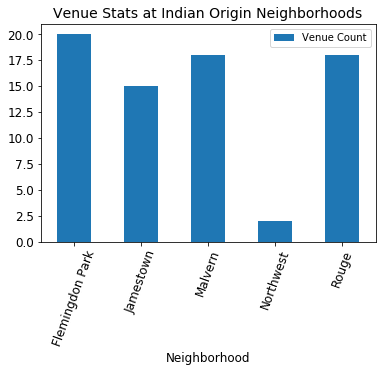

In [72]:
import matplotlib.pyplot as plt

Indian_neighborhood_stat.plot(kind='bar', x='Neighborhood',y='Venue', label='Venue Count', fontsize=12)
plt.title('Venue Stats at Indian Origin Neighborhoods', fontsize=14)
plt.xticks(rotation=70)
plt.xlabel('Neighborhood', fontsize=12)
plt.show()

#### Restaurant Venue Stats at Indian Origin Neighborhoods

In [73]:
Indian_neighborhood_restaurant_venues = Indian_neighborhood_venues.loc[Indian_neighborhood_venues['Venue Category'].str.contains('Restaurant')]

In [74]:
Indian_neighborhood_restaurant_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Flemingdon Park,43.725900,-79.340923,Sorento Restaurant,43.726575,-79.341989,Italian Restaurant
6,Flemingdon Park,43.725900,-79.340923,Kaiseki Yu-Zen Hashimoto,43.720931,-79.337185,Japanese Restaurant
7,Flemingdon Park,43.725900,-79.340923,Swiss Chalet Rotisserie & Grill,43.726737,-79.341403,Restaurant
8,Flemingdon Park,43.725900,-79.340923,Diwan,43.725002,-79.332019,Middle Eastern Restaurant
9,Flemingdon Park,43.725900,-79.340923,JOEY Don Mills,43.733990,-79.344734,Restaurant
30,Jamestown,43.739416,-79.588437,McDonald's,43.741757,-79.584230,Fast Food Restaurant
32,Jamestown,43.739416,-79.588437,NORI SUSHI,43.742775,-79.586985,Japanese Restaurant
36,Malvern,43.806686,-79.194353,Caribbean Wave,43.798558,-79.195777,Caribbean Restaurant
37,Malvern,43.806686,-79.194353,Wendy's,43.802008,-79.198080,Fast Food Restaurant
38,Malvern,43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant


In [75]:
Indian_neighborhood_restaurants_stat = Indian_neighborhood_restaurant_venues.groupby(['Neighborhood'])['Venue'].count().to_frame()
Indian_neighborhood_restaurants_stat = Indian_neighborhood_restaurants_stat.reset_index()

#### Restaurant venues per Indian Neighborhood 

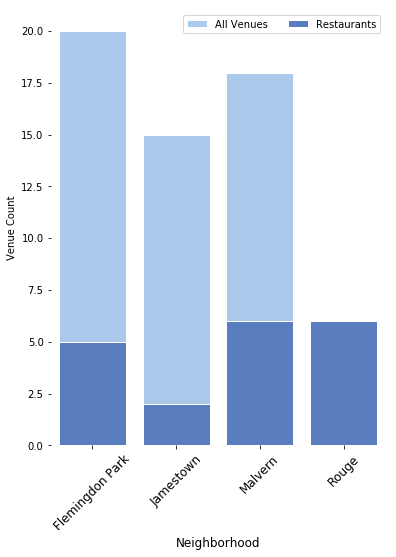

In [76]:
import seaborn as sns

f, ax = plt.subplots(figsize = (6,8))
sns.set_color_codes('pastel')
sns.barplot(x = 'Neighborhood', y = 'Venue', data = Indian_neighborhood_stat,
            label = 'All Venues', color = 'b', edgecolor = 'w')
sns.set_color_codes('muted')
sns.barplot(x = 'Neighborhood', y = 'Venue', data = Indian_neighborhood_restaurants_stat,
            label = 'Restaurants', color = 'b', edgecolor = 'w')
ax.legend(ncol = 2, loc = 'upper right', fontsize=10)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=10)
plt.xlabel('Neighborhood',fontsize=12)
plt.ylabel('Venue Count', fontsize=10)
sns.despine(left = True, bottom = True)
plt.show()

### Cluster Indian Neighborhoods via KMeans Clustering

In [77]:
# one hot encoding
Indian_neighborhood_onehot = pd.get_dummies(Indian_neighborhood_venues[['Venue Category']], prefix="", prefix_sep="")

Indian_neighborhood_onehot2 = Indian_neighborhood_onehot.assign(neighborhood = Indian_neighborhood_venues["Neighborhood"].to_list())

fixed_columns = [Indian_neighborhood_onehot2.columns[-1]] + list(Indian_neighborhood_onehot2.columns[:-1])
Indian_neighborhood_onehot2 = Indian_neighborhood_onehot2[fixed_columns]



In [78]:
Indian_neighborhood_onehot2.head()

,neighborhood,African Restaurant,Arts & Crafts Store,Bank,Bar,Beer Store,Bike Shop,Burger Joint,Bus Line,Bus Station,...,Pharmacy,Pizza Place,Rental Car Location,Restaurant,Sandwich Place,Spa,Sporting Goods Shop,Supermarket,Trail,Women's Store
0,Flemingdon Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Flemingdon Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Flemingdon Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Flemingdon Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Flemingdon Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Group rows by neighborhood by taking the mean of the frequency of occurrence of each category

In [79]:
Indian_neighborhood_grouped = Indian_neighborhood_onehot2.groupby('neighborhood').mean().reset_index()

In [80]:
Indian_neighborhood_grouped

,neighborhood,African Restaurant,Arts & Crafts Store,Bank,Bar,Beer Store,Bike Shop,Burger Joint,Bus Line,Bus Station,...,Pharmacy,Pizza Place,Rental Car Location,Restaurant,Sandwich Place,Spa,Sporting Goods Shop,Supermarket,Trail,Women's Store
0,Flemingdon Park,0.000000,0.000000,0.05,0.05,0.050000,0.05,0.05,0.000000,0.000000,...,0.000000,0.0,0.0,0.1,0.000000,0.000000,0.05,0.05,0.000000,0.05
1,Jamestown,0.000000,0.000000,0.00,0.00,0.066667,0.00,0.00,0.066667,0.000000,...,0.066667,0.2,0.0,0.0,0.066667,0.000000,0.00,0.00,0.000000,0.00
2,Malvern,0.055556,0.055556,0.00,0.00,0.000000,0.00,0.00,0.000000,0.055556,...,0.000000,0.0,0.0,0.0,0.055556,0.055556,0.00,0.00,0.055556,0.00
3,Northwest,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,...,0.000000,0.0,0.5,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.00
4,Rouge,0.055556,0.055556,0.00,0.00,0.000000,0.00,0.00,0.000000,0.055556,...,0.000000,0.0,0.0,0.0,0.055556,0.055556,0.00,0.00,0.055556,0.00


In [81]:
Indian_neighborhood_grouped.drop(columns='neighborhood', inplace= True)

##### Finding Optimal k using Elbow visualizer and Applying KMeans Algorithm

In [95]:
Sum_of_squared_distances = []
K = range(1,5)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Indian_neighborhood_grouped)
    Sum_of_squared_distances.append(km.inertia_)

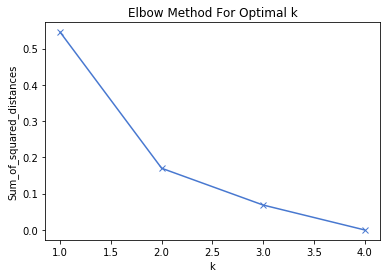

In [96]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [99]:
k = 3  # 3 seems best optimal value based on elbow method finding

model = KMeans(n_clusters=k, random_state = 0)
model.fit(Indian_neighborhood_grouped)
model.labels_

array([0, 0, 2, 1, 2], dtype=int32)

##### Sorting the Indian Neighborhood Postal Dataframe by Neighborhood in order to map the Clusters

In [83]:
Indian_neighborhood = Indian_neighborhood.sort_values('Neighborhood', ascending= True).reset_index(drop = True)

###### Appending the Clusters with respective Neighborhoods in Toronto Postal Dataframe

In [93]:
Indian_neighborhood = Indian_neighborhood.assign(Cluster = model.labels_)

In [94]:
Indian_neighborhood

,Neighborhood,Top_Ethnic_Origin,PostalCode,Borough,Latitude,Longitude,Cluster
0,Flemingdon Park,Indian,M3C,North York,43.725900,-79.340923,0
1,Jamestown,Indian,M9V,Etobicoke,43.739416,-79.588437,0
2,Malvern,Indian,M1B,Scarborough,43.806686,-79.194353,2
3,Northwest,Indian,M9W,Etobicoke,43.706748,-79.594054,1
4,Rouge,Indian,M1B,Scarborough,43.806686,-79.194353,2


### Visualizing the Clusters 

In [86]:
# Toronto Coordinates
Latitude = 43.6532
Longitude = -79.3832

In [106]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np

# create map
map_clusters = folium.Map(location=[Latitude, Longitude], zoom_start=11)
kclusters = 3

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Indian_neighborhood['Latitude'], Indian_neighborhood['Longitude'], Indian_neighborhood['Neighborhood'], Indian_neighborhood['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color='Yellow',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.9).add_to(map_clusters)
       
map_clusters

### Favourable Location recommendation 

Based on the data exploration on Indian neighborhoods in Toronto, we can observe Flemingdon Park and Jamestown to be the best suitable locations to setup Indian restaurant.  

Favourable points to justify the observation:

1. Flemingdon Park and Jamestown has high percentage of Indian origin
2. Being Indian Origin location, we dont see any Indian Restaurant venues at these locations, so the competition should be less
3. In terms of Clusters, Cluster 0 - Jamestown and Flemingdon Park has more venues which will attract more people gatherings and thereby will attract them to the restaurant as well. Example - Groceries, Concert hall, Clothing stores. So having Indian restaurant at close proximities near these venues should give more advantage of pulling more customers.

Malvern and Rouge cluster looks second best optimal location to setup Indian restaurant.
